## Load Imports

In [1]:
# python imports
import os
import re
import json
from math import pi

# third-party imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

## Config

In [2]:
PREFIX = 'scenario-3-4'

DRAW_TITLE = True
SAVE_FIG = True

OUTPUT_FIG = 'imgs'
EXTENSION = 'pdf'

## Globals variables

In [3]:
COLUMNS = [
    'base_score', 'cve_published_date', 'exploit_count', 'exploit_published_date', 'epss', 'topology', 'asset_type', 
    'environment', 'sensitive_data', 'end_of_life', 'critical_asset', 'attack_type_arbitrary_code_execution', 
    'attack_type_defense_in_depth', 'attack_type_denial_of_service', 'attack_type_elevation_of_privilege', 
    'attack_type_information_disclosure', 'attack_type_memory_leak', 'attack_type_none', 'attack_type_proof_of_concepts', 
    'attack_type_remote_code_execution', 'attack_type_security_feature_bypass', 'attack_type_spoofing', 
    'attack_type_sql_injection', 'attack_type_tampering', 'attack_type_xss', 'attack_type_zero_day', 
    'availability_impact_high', 'availability_impact_low', 'availability_impact_none', 'confidentiality_impact_high', 
    'confidentiality_impact_low', 'confidentiality_impact_none', 'integrity_impact_high', 'integrity_impact_low', 
    'integrity_impact_none', 'part_application', 'part_hardware', 'part_operating_system', 'vendor_adobe', 'vendor_apple', 
    'vendor_cisco', 'vendor_debian', 'vendor_google', 'vendor_ibm', 'vendor_linux', 'vendor_microsoft', 'vendor_oracle', 
    'vendor_other', 'vendor_redhat', 'mitre_top_25', 'owasp_top_10', 'security_advisory', 'audience', 'google_interest',
    'google_trend_decreasing', 'google_trend_increasing', 'google_trend_none', 'google_trend_steady']

SEVERITY_LABELS = ['LOW', 'MEDIUM', 'HIGH', 'CRITICAL']
RISK_LABELS = ['LOW', 'MODERATE', 'IMPORTANT', 'CRITICAL']

## Utils

In [4]:
def flatten_dict(vulns_dist, keys):
    tmp_list = {key: [] for key in keys}

    for dist in vulns_dist:
        for key, value in dist.items():
            tmp_list[key].append(value)

    return tmp_list

In [5]:
# https://en.wikipedia.org/wiki/Shoelace_formula
def poligon_area(theta, r):
    # turn radial grid points into (x, y)
    x = r[:-1] * np.sin(theta[:-1])
    y = r[:-1] * np.cos(theta[:-1])

    return 0.5 * np.abs(np.dot(x[:-1], np.roll(y[:-1], 1)) - np.dot(y[:-1], np.roll(x[:-1], 1)))

In [6]:
def read_process_data(network_name):
    feature_importances = {name: [] for name in COLUMNS}

    cvss_base_severity = list()
    cvss_risk_score = list()

    frape_base_severity = list()
    frape_risk_score = list()

    cvss_cdf = pd.DataFrame(columns=COLUMNS)
    frape_cdf = pd.DataFrame(columns=COLUMNS)

    cvss_abs_values = pd.DataFrame(columns=COLUMNS)
    frape_abs_values = pd.DataFrame(columns=COLUMNS)

    occurrences = 0

    for file in os.listdir(f'../output/{network_name}/'):
        if file.endswith('.json'):
            with open(f'../output/{network_name}/{file}') as f:

                file = json.load(f)

                # loading values

                features = pd.Series(file['feature_importances'])

                cvss_severity = file['stats']['cvss']['base_severity']
                frape_severity = file['stats']['frape']['base_severity']

                cvss_risk = file['stats']['cvss']['risk_score']
                frape_risk = file['stats']['frape']['risk_score']

                cvss_abs = pd.DataFrame.from_records(file['stats']['cvss']['abs_values'])
                frape_abs = pd.DataFrame.from_records(file['stats']['frape']['abs_values'])

                # loading feature importances

                for name, value in zip(features.index, features.values):
                    feature_importances[name].append(value)

                # loading base severity and risk score

                cvss_base_severity.append(flatten_dict(cvss_severity, SEVERITY_LABELS))
                frape_base_severity.append(flatten_dict(frape_severity, SEVERITY_LABELS))

                cvss_risk_score.append(flatten_dict(cvss_risk, RISK_LABELS))
                frape_risk_score.append(flatten_dict(frape_risk, RISK_LABELS))

                # normalizing values

                cvss_frape_abs = pd.concat([cvss_abs, frape_abs])

                cvss_abs = cvss_abs / cvss_frape_abs.max(axis=0)
                frape_abs = frape_abs / cvss_frape_abs.max(axis=0)

                if occurrences == 0:
                    cvss_abs_values = cvss_abs
                    frape_abs_values = frape_abs
                else:
                    cvss_abs_values += cvss_abs
                    frape_abs_values += frape_abs

                occurrences += 1

    # calcularing mean values

    cvss_abs_values /= occurrences
    frape_abs_values /= occurrences

    # sorting feature importance values

    feature_importances = pd.DataFrame(feature_importances, columns=feature_importances.keys())

    feature_importances_std = feature_importances.std()
    feature_importances = feature_importances.mean()

    feature_importances.drop(labels=['cve_published_date', 'exploit_published_date', 
                                     'vendor_other', 'attack_type_none'], inplace=True)


    feature_importances = feature_importances.sort_values(ascending=False).head(9)
    feature_importance_names = feature_importances.index.tolist()
    feature_importances_std = feature_importances_std[feature_importance_names].values

    # filtering absolute values

    cvss_abs_values = cvss_abs_values[feature_importance_names]
    frape_abs_values = frape_abs_values[feature_importance_names]
    
    return cvss_abs_values, frape_abs_values

In [7]:
def calc_values(cvss_stats, frape_stats):
    cvss_area = list()
    frape_area = list()

    for key in range(len(cvss_stats)):

        cvss = cvss_stats.iloc[[key]]
        cvss = np.squeeze(cvss.values).tolist()

        frape = frape_stats.iloc[[key]]
        frape = np.squeeze(frape.values).tolist()

        labels = cvss_stats.columns.tolist()

        angles = np.linspace(start=0, stop=2 * np.pi, num=len(labels), endpoint=False).tolist()

        # closing the polygon
        cvss += cvss[:1]
        frape += frape[:1]
        angles += angles[:1]

        cvss_area.append(poligon_area(angles, cvss))
        frape_area.append(poligon_area(angles, frape))
    
    limit = len(cvss_area)
    
    cvss_area = np.array(cvss_area)[:limit]
    frape_area = np.array(frape_area)[:limit]
    
    # normalizing area values
    
    max_values = [*cvss_area, *frape_area]
    
    cvss_area = cvss_area / max(max_values)
    frape_area = frape_area / max(max_values)
        
    # calculating delta values
    
    delta = [frape - cvss for cvss, frape in zip(cvss_area, frape_area)]

    min_value = min(delta)
    min_index = delta.index(min_value)
    
    return cvss_area, frape_area, min_value, min_index, limit

In [8]:
def plot_inner(ax, cvss_area, frape_area, min_value, min_index, limit, text_offset=(0, 0)):    
    ax.plot(range(limit), cvss_area, label='CVSS')
    ax.plot(range(limit), frape_area, label='FRAPE')

    ax.annotate(f'FRAPE Max Gain ({round(abs(min_value) * 100)}%)',
                xy=(min_index, frape_area[min_index]), xycoords='data',
                bbox=dict(boxstyle='round,pad=0.2', fc='whitesmoke', alpha=0.9),
                xytext=text_offset, textcoords='offset points')

    ax.annotate('', xy=(min_index, frape_area[min_index]), 
                xytext=(min_index, cvss_area[min_index]),
                arrowprops=dict(arrowstyle="<->", color='black', linestyle='--'))      

    ax.legend(prop={'size': 11})
    ax.grid(True, linestyle='--', alpha=.25)

## Loading data

In [9]:
cvss_abs_less, frape_abs_less = read_process_data('Network03')
cvss_abs_more, frape_abs_more = read_process_data('Network04')

## Running

In [10]:
cvss_area_less, frape_area_less, min_value_less, min_index_less, limit_less = calc_values(cvss_abs_less, frape_abs_less)
cvss_area_more, frape_area_more, min_value_more, min_index_more, limit_more = calc_values(cvss_abs_more, frape_abs_more)

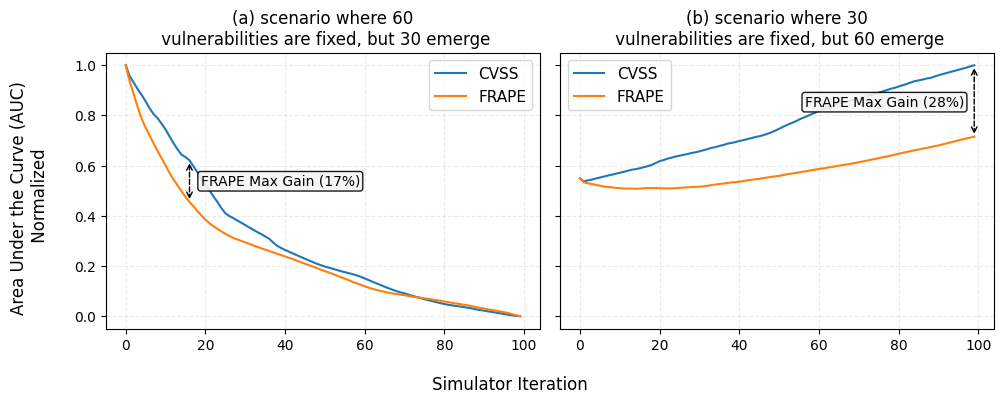

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True, tight_layout=True)

fig.supylabel('Area Under the Curve (AUC)\n Normalized', horizontalalignment='center')
fig.supxlabel('Simulator Iteration')

if DRAW_TITLE:
    ax1.set_title('(a) scenario where 60\n vulnerabilities are fixed, but 30 emerge')
    ax2.set_title('(b) scenario where 30\n vulnerabilities are fixed, but 60 emerge')

plot_inner(ax1, cvss_area_less, frape_area_less, min_value_less, min_index_less, limit_less, (8, 12))
plot_inner(ax2, cvss_area_more, frape_area_more, min_value_more, min_index_more, limit_more, (-122, 22))

if SAVE_FIG:
    plt.savefig(f'{OUTPUT_FIG}/{PREFIX}-absolute-auc-graph.{EXTENSION}', bbox_inches='tight', dpi=1200)

plt.show()